<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Price Prediction

--- 
# Part 3: Model & Evaluation

After understood the correlations in the features, One-hot encoder on Categorical Data will be performed for converting Categorical data to numerical. Then all the data is ready for modeling, I used Standard Scalar from scikit learn to normalize the features before applying Data Science techniques.

Baseline Linear Regression model has run first to test how the model is fit. When there's the common overfitting issue, I've tried the regularization to reduce the overfitting by another 3 types of Ridge (L2), Lasso (L1), and ElasticNet. 
Model Tuning has been done by comparing differnt model evaluation matrix accross all models, and I have attempted to craft a model with as accurate as possible.

---

### Contents:
- [1. Importing Libraries](#1.-Importing-Libraries)
- [2. Data Import](#2.-Data-Import)
- [3. Create Feature Matrix and Taget](#3.-Create-Feature-Matrix-and-Taget)
- [4. Model-Selection-&-Evaluation](#4.-Model-Selection-&-Evaluation)
- [5. Logarithmic Transformation of Sales Price](#5.-Logarithmic-Transformation-of-Sales-Price)
- [6. Business Summary](#6.-Businesss-Summary)
- [7. Model Limitation & Future Work](#7.-Model-Limitation-&-Future-Work)

---

# 1. Import Libraries

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV 
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from tqdm import tqdm as progress_bar

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

---

# 2. Data Import

---

## 2.1 Load Train & Test Datasets

In [2]:
#import train & test cleaned dataset after Part2

path = "../datasets/part2/"
df_train = pd.read_csv(path + "train_clean_with_transform_engineering_part2.csv", keep_default_na = False)
df_test  =pd.read_csv(path + "test_clean_with_transform_engineering_part2.csv", keep_default_na = False)

In [3]:
df_train.head()

,Id,MS SubClass,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Total Porch SF,Total Bath,Age of Built,has 2nd Flr,has Bsmt,has Fireplace,has Garage,has Pool,has Porch,SalePrice_log
0,109,60,RL,13517,Pave,na,2,Lvl,1,CulDSac,...,44,2.5,34,1,1,0,1,0,1,11.779129
1,544,60,RL,11492,Pave,na,2,Lvl,1,CulDSac,...,74,3.5,13,1,1,1,1,0,1,12.301383
2,153,20,RL,7922,Pave,na,1,Lvl,1,Inside,...,52,2.0,57,0,1,0,1,0,1,11.599103
3,318,60,RL,9802,Pave,na,1,Lvl,1,Inside,...,100,2.5,4,1,1,0,1,0,1,12.066811
4,255,50,RL,14235,Pave,na,2,Lvl,1,Inside,...,59,2.0,110,1,1,0,1,0,1,11.838626


In [4]:
df_test.head()

,Id,MS SubClass,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Total SF,Total Porch SF,Total Bath,Age of Built,has 2nd Flr,has Bsmt,has Fireplace,has Garage,has Pool,has Porch
0,2658,190,RM,9142,Pave,Grvl,1,Lvl,1,Inside,...,2948,172,2.0,96,1,1,0,1,0,1
1,2718,90,RL,9662,Pave,na,2,Lvl,1,Inside,...,3934,170,2.0,29,0,1,0,1,0,1
2,2414,60,RL,17104,Pave,na,2,Lvl,1,Inside,...,2150,124,3.5,0,1,1,1,1,0,1
3,1989,30,RM,8520,Pave,na,1,Lvl,1,Inside,...,1936,184,1.0,84,0,1,0,1,0,1
4,625,20,RL,9500,Pave,na,2,Lvl,1,Inside,...,2788,261,2.5,46,0,1,1,1,0,1


---

# 3. Create Feature Matrix and Taget

---

In [5]:
obj_cols = df_train.dtypes[df_train.dtypes == 'object']
obj_cols = list(obj_cols.index)

In [6]:
# Create dummy variables for one-hot encode the Categorical Data
df_train =pd.get_dummies(df_train,columns = obj_cols, drop_first = True)
df_test =pd.get_dummies(df_test,columns = obj_cols, drop_first = True)

In [7]:
features = df_train.drop(columns=['SalePrice_log', 'SalePrice']).columns
X = df_train[features]
y= df_train['SalePrice']
y_2 = df_train['SalePrice_log']

In [8]:
print(X.shape)

(2049, 181)


In [9]:
missing_cols = set(df_train.columns)-set(df_test.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[X.columns]

In [10]:
# Ensure both X in train data & test data have the same columns
df_test.shape

(878, 181)

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
df_test.shape

(878, 181)

In [13]:
df_train.shape

(2049, 183)

In [14]:
# Scaling
ss = StandardScaler()
scalerX = ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

df_test_sc = ss.transform(df_test)

# 4. Model Selection & Evaluation

In [15]:
results = {}

In [16]:
#defin model Evaluation Matrix(errors, scores)
def Model_Eval_matrix(model,X_train, y_train, y_true, y_pred):
    
    train_score,test_score,mae, r2, rmse = [], [], [],[],[]
    
    # Collect the scores/errors for each model
    train_score=model.score(X_train, y_train)
    test_score =model.score(X_test, y_true)
    mae.append(mean_absolute_error(y_true, y_pred))
    r2.append(r2_score(y_true, y_pred))
    rmse.append(mean_squared_error(y_true, y_pred))
    # Round for convenience.
    return {
        "train_score":np.round(np.mean(train_score),3),
        "test_score":np.round(np.mean(test_score),3),
        "mae": np.round(np.mean(mae)),
        "r2": np.round(np.mean(r2), 3),
        "rmse": np.round(np.sqrt(np.mean(rmse))),
    }

## Linear Regression

In [17]:
%%time
lr = LinearRegression()
cross_val_score(lr,X,y,cv=10)
lr.fit(X_train, y_train)
y_Pred = lr.predict(X_test)
results[('lm','o')] = Model_Eval_matrix(lr, X_train, y_train, y_test, y_Pred)
results[('lm','o')]

Wall time: 406 ms


{'train_score': 0.929,
 'test_score': -1.9175703459995795e+21,
 'mae': 228384936779116.0,
 'r2': -1.9175703459995795e+21,
 'rmse': 3585853900135635.0}

## Comment：

The train score is quite good while the test score is really bad, and r2 score is negative, this probably due to the issue of overfitting and redundant features. Lasso, Ridge, and Elastic Net models are forms of regularized linear techniques found in General Linear Models, I will try these 3 models.

## Lasso

In [18]:
%%time
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)
print(f'optimal lasso alpha is {optimal_lasso.alpha_}')

lasso = Lasso(alpha=optimal_lasso.alpha_)
cross_val_score(lasso, X, y, cv=10)
lasso.fit(X_train, y_train)
y_Pred = lasso.predict(X_test)
results[('lasso','o')] = Model_Eval_matrix(lasso, X_train, y_train, y_test, y_Pred)
results[('lasso','o')]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal lasso alpha is 471.2256110039473


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453486614984.6808, tolerance: 1141957619.934621
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495093744255.7556, tolerance: 1174409542.4464788
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482256238768.4967, tolerance: 1172530308.1398697
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergence

Wall time: 6.78 s


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482924425437.5498, tolerance: 1169507054.7205133
  model = cd_fast.enet_coordinate_descent(


{'train_score': 0.922,
 'test_score': 0.912,
 'mae': 16821.0,
 'r2': 0.912,
 'rmse': 24303.0}

In [19]:
lasso_coefs = pd.DataFrame({'Feature': X.columns,
                           'coef': lasso.coef_,
                           'abs_coef': abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs[:10]

,Feature,coef,abs_coef
37,Total SF,35493.110999,35493.110999
6,Overall Qual,14165.103524,14165.103524
8,Year Built,8909.540301,8909.540301
19,Bsmt Unf SF,-7656.540748,7656.540748
81,Neighborhood_NridgHt,7354.955774,7354.955774
42,has Bsmt,-6804.964351,6804.964351
87,Neighborhood_StoneBr,6153.161053,6153.161053
1,MS SubClass,-6015.043257,6015.043257
178,Sale Type_New,5439.739897,5439.739897
2,Lot Area,5244.820172,5244.820172


## Comments:
1. Lasso Regression assigns a penalty to the coefficients in the linear model and eliminates variables with coefficients that zero. This shrinkage process where data values are shrunk to a central point such as a mean.
2. From the model evaluation matrix, it can be observed that it has a high mean score of 0.922 for train data, and 0.912 for test unseen data, it's slightly lower than the baseline score. 
3. The r2 score is 0.912 which means that this Lasso model is able to explain 91.2% of sales price variation.

### Lasso Model Tuning by using GridSearchCV

In [20]:
%%time

tol = 0.1
grid_search = GridSearchCV(
    estimator=Lasso(tol=tol, selection="random", random_state=42),
    param_grid={"alpha": [2 ** x for x in range(-8, 4)] + list(range(12, 65, 4))},
    cv=KFold(n_splits=4),
    n_jobs=-1,
)

grid_search.fit(X, y)
optimal_alpha=grid_search.best_params_["alpha"]
print(f'optimal lasso alpha is {optimal_alpha}')
lassoGS = Lasso(alpha=optimal_alpha)

cross_val_score(lassoGS, X, y, cv=10)
lassoGS.fit(X_train, y_train)
y_Pred = lassoGS.predict(X_test)
results[('lassoGridSearch','o')] = Model_Eval_matrix(lassoGS, X_train, y_train, y_test, y_Pred)
results[('lassoGridSearch','o')]

optimal lasso alpha is 64


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462022597290.4561, tolerance: 1141957619.934621
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477504507628.3479, tolerance: 1174409542.4464788
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475052225525.28955, tolerance: 1172530308.1398697
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergenc

Wall time: 10.6 s


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477634027185.391, tolerance: 1169507054.7205133
  model = cd_fast.enet_coordinate_descent(


{'train_score': 0.928,
 'test_score': 0.911,
 'mae': 17049.0,
 'r2': 0.911,
 'rmse': 24481.0}

## Comment:

1. GridSearch is a process of performing hyperparameter tuning in order to determine the optimal values for a given model. There might be some room for model improvement, and one of important factor in the performance is the hyperparameter. Once we set appropriate values for these hyperparameters, the performance of a model can improve significantly.

2. But comparing the Lasso GridSearch model vs Lasso Model, there is not much significant improvement, which in another way implies the Lasso model has a quite good and stable performance.  

## Ridge

In [21]:
%%time
# Baseline Model
ridge_alphas = np.linspace(.1,500,100)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train,y_train)
print(f'optimal ridge alpha is {optimal_ridge.alpha_}')

ridge = Ridge(alpha=optimal_ridge.alpha_)
cross_val_score(ridge, X, y, cv=10)
ridge.fit(X_train, y_train)
y_Pred = ridge.predict(X_test)
results[('ridge','o')] = Model_Eval_matrix(ridge, X_train, y_train, y_test, y_Pred)
results[('ridge','o')]

optimal ridge alpha is 70.79292929292929
Wall time: 8.29 s


{'train_score': 0.925,
 'test_score': 0.904,
 'mae': 17601.0,
 'r2': 0.904,
 'rmse': 25427.0}

## Comment:

1. Ridge assigns a penalty that is the squared magnitude of the coefficients to the loss function multiplied by lambda. As Lasso does, ridge also adds a penalty to coefficients the model overemphasizes. The value of lambda also plays a key role in how much weight you assign to the penalty for the coefficients. The larger your value of lambda, the more likely your coefficients get closer and closer to zero. Unlike lasso, the ridge model will not shrink these coefficients to zero.

2. As Ridge does not eliminate coefficients in our model even if the variables are irrelevant. This can be negative if in future we have more features than observations.

3. From the model, it can be observed that it has a high train score of 0.925 and test score of 0.904, the RMSE is 25427.
4. Comparing to Lasso & Lasso GridSearchCV Model, it has a slightly low r2 score-0.904 which means that the Ridge model is able to explain 90.4% of sales price variation.

### Ridge Model Tuning by using GridSearchCV

In [22]:
%%time

grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid={"alpha": [2 ** x for x in range(-8, 4)] + list(range(12, 65, 4))},
    cv=KFold(n_splits=4),
    n_jobs=-1,
)

grid_search.fit(X, y)
optimal_alpha=grid_search.best_params_["alpha"]
print(f'optimal ridge alpha is {optimal_ridge.alpha_}')

ridgeGS = Ridge(alpha=optimal_ridge.alpha_)
cross_val_score(ridgeGS, X, y, cv=10)
ridgeGS.fit(X_train, y_train)
y_Pred = ridgeGS.predict(X_test)
results[('ridgeGridSearch','o')] = Model_Eval_matrix(ridgeGS, X_train, y_train, y_test, y_Pred)
results[('ridgeGridSearch','o')]

optimal ridge alpha is 70.79292929292929
Wall time: 998 ms


{'train_score': 0.925,
 'test_score': 0.904,
 'mae': 17601.0,
 'r2': 0.904,
 'rmse': 25427.0}

## Comments:

Same as LassoGridSearchCV, I also tried to see if any room to improve the Ridge model, how it doesn't show the space for improving.

## Elastic Net

In [23]:
%%time
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,verbose=1)

optimal_enet.fit(X_train, y_train)

print(f'optimal ElasticNet alpha is {optimal_enet.alpha_}')

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

cross_val_score(enet, X, y, cv=10)
enet.fit(X_train, y_train)
y_Pred = enet.predict(X_test)
results[('ElasticNet','o')] = Model_Eval_matrix(enet, X_train, y_train, y_test, y_Pred)
results[('ElasticNet','o')]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

..................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   18.8s finished


optimal ElasticNet alpha is 485.60740660818794


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451467393437.7956, tolerance: 1141957619.934621
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493291627957.6084, tolerance: 1174409542.4464788
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480717184241.6549, tolerance: 1172530308.1398697
  model = cd_fast.enet_coordinate_descent(
C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergence

Wall time: 21.9 s


C:\Users\liubin\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483470431101.2469, tolerance: 1169507054.7205133
  model = cd_fast.enet_coordinate_descent(


{'train_score': 0.922,
 'test_score': 0.912,
 'mae': 16831.0,
 'r2': 0.912,
 'rmse': 24318.0}

$$ \text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \alpha\rho\sum_{j=1}^p |\beta_j| + \alpha(1-\rho)\sum_{j=1}^p \beta_j^2$$

## Comment:
1. Elastic Net combines characteristics of both lasso and ridge. Elastic Net reduces the impact of different features while not eliminating all of the features.

2. ElasticNet in sklearn has two parameters: alpha: the regularization strength. l1_ratio: the amount of L1 vs L2 penalty (i.e.,  𝜌 ). An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.

3. The high r2 score means that the model is able to explain 91.2% of sale price variation. The RMSE is 24318
4. The optimal l1_ratio is 1, which shows that Lasso model was found to be optimal.

## Plotting Predictions against Actual Values

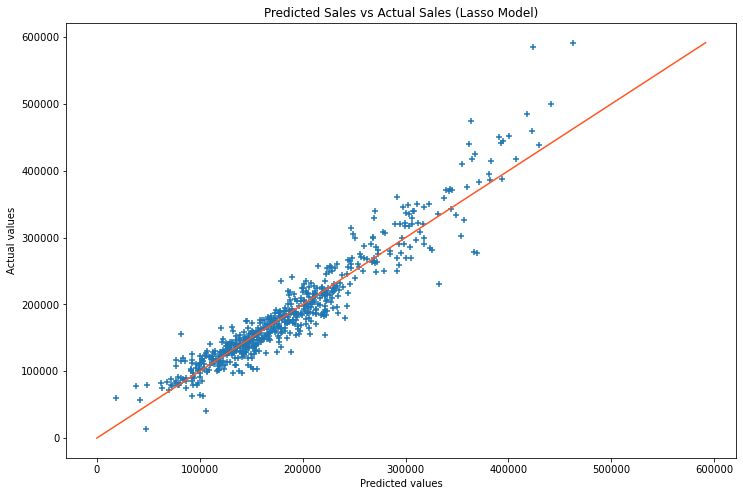

In [24]:
#Generates a list of the model's predictions for the test bloc
y_Pred = lasso.predict(X_test)

plt.figure(figsize=(12,8))
plt.scatter(y_Pred,y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title("Predicted Sales vs Actual Sales (Lasso Model)")

plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = '#FF5722');

## Comment:

The Model certainly look very strong. There are very few poor predictions and it don't appear to be significantly underpredicting or overpredicting on any stretch of data. 

## Model Selection Summary:

In general, Lasso Model seemed to outperform the other models with feature engineering, while ElasticNet also gave almost same score as Lasso model. I will choose Lasso Model as my product model and for Kaggle submission, as it gives a good prediction of 91.9% by shinking and removing non-important features, which helps to reduce the variance without a substantial increase of the bias. 

# 5. Output Model Predictions for Kaggle Submission

In [25]:
# Choose my preferred Lasso Model for submission
y_pred = lasso.predict(df_test_sc)
submission = pd.DataFrame(y_pred, columns=['SalePrice'])
submission['Id'] = df_test['Id']
submission = submission[['Id', 'SalePrice']]
submission.head()

,Id,SalePrice
0,2658,127875.815762
1,2718,159520.408608
2,2414,221665.139769
3,1989,106684.378883
4,625,163322.192418


In [26]:
path = "../datasets/Kaggle Submission/"
submission.to_csv(path + "submission.csv", index = False)

# 6. Business Recommendations

In [27]:
lasso_coefs = pd.DataFrame({'Feature': X.columns,
                           'coef': lasso.coef_,
                           'abs_coef': abs(lasso.coef_)})
lasso_coefs.sort_values('coef', inplace=True, ascending=False)
lasso_coefs[:5] # Top 5 features

,Feature,coef,abs_coef
37,Total SF,35493.110999,35493.110999
6,Overall Qual,14165.103524,14165.103524
8,Year Built,8909.540301,8909.540301
81,Neighborhood_NridgHt,7354.955774,7354.955774
87,Neighborhood_StoneBr,6153.161053,6153.161053


In [28]:
# Scale back the coefficients 
lasso_coef = pd.DataFrame(
    data={
        'scaleX' : scalerX.scale_,
        'norm_coef' : lasso.coef_
    },
    columns=[ 'norm_coef', 'scaleX']
)
lasso_coef['rescaled_coef'] = lasso_coef.norm_coef / lasso_coef.scaleX
lasso_coef=lasso_coef.T
lasso_coef.T.reset_index(drop=True, inplace=True)
lasso_coef.columns = X.columns

In [29]:
variables = ['Total SF', 'Overall Qual','Year Built','Neighborhood_NridgHt','Neighborhood_StoneBr']
lasso_coef[variables]

,Total SF,Overall Qual,Year Built,Neighborhood_NridgHt,Neighborhood_StoneBr
norm_coef,35493.110999,14165.103524,8909.540301,7354.955774,6153.161053
scaleX,759.291904,1.433909,30.236463,0.232191,0.133426
rescaled_coef,46.745014,9878.665543,294.662120,31676.263352,46116.828458


## Comment:

The recommendation will be based on Lasso model and inferential statistics. The recommendations will be relevant to the following stakeholders: home buyers, housing agent, developers and home sellers based on the top 5 coefficients, the simplest and the most important, the best to stakeholders to understand. The model confirms 4 broad categories: living space, quality of house, location and age of building are important predictors of a price of housing in Ames, Iowa. 

My recommendations are:

**The 1st Category is Living Space**

Based on Lasso model, the following coefficients related to living space are significant:   

- Total SF = Total area both above ground and below ground square feet 
  - is postively high correlated with Sales Price
  - A one unit change in total area, the sale price will increase by 46.7 dollar, holding others constant.

#### Implications for stakeholders

- Home Buyers
    - Home buyers can use living space to estimate the actual price of the house. Normally, sellers or agents will post a higher price on property portals to fetch the highest selling price. Home buyers can have a rough estimate of the actual price by assessing the total living area. As such, home buyers can give an appropriate offer to the seller so as to enhance the opportunity of securing the property. 
    - Generally for home buyers on a tight budget should avoid looking for big houses. 
- Home sellers( including house owner, devleopers, housing agent)
    -  when marketing their property, they should leverage on living area to achieve a better bargain. Living area should include basement area and garage area as they have an impact on selling price. Meaning, the bigger the area, the higher the sale price. Therefore, small houses should not be asking for a high sale price otherwise no buyer would buy. 
    - Sellers should take note or take care on the completeness of basement which it might be neglected. As an incompleted Basement area will cause your buyer have more space to bargin on the sales price.
    - Developers, when there is a limit on how big the house can be built above ground with completed basement.

**The 2nd Category is House Quality**

Based on Lasso model, the following coefficients related to house quality are significant:     

- Overall Qual = Rates of the overall material and finish of the house 
  - is postively correlated with Sales Price
  - A one unit change in total area, the sale price will increase by 9878.6 dollar, holding others constant.
  
#### Implications for stakeholders
- Home Buyers
    - Before buying a property, buyers should assess the overall material finish of the house. Houses that have execellent material finish tends to have a higher sale price as the two variables are positively correlated. Therefore, buyers need to give a higher offer to house that has a better material finish (holding other variables constant) so as to increase the probability of the offer being accepted. 
- Home sellers
    - Sellers could highlight the material quality of the house during marketing. For developers, in order to sell the house at a premium, the developer can use quality materials and ensure good worksmanship.
    - Sellers could renovate their house or at the least renovate the kitchen or exteior to boost sale price. 


**The 3rd Category is Location**

Based on lasso model, Northridge Heights & Stone Brook were found to be significant. 

- If the property is neighbored with Northridge Heights, the sale price will increase by 31676 dollar, holding other variables constant.  
- If the property is neighbored with Stone Brook , the sale price will increase by 46116 dollar, holding other variables constant.  
    
* Houses at Northridge Heights neighbourhood tend to have a higher sale price. Based on outside research the NH population is highly educated, 74% of the population has an associate degree or higher. Secondly, NH also has a very high median income 105,583 usd which is much higher than the national average of 33,706 usd. Besides that, NH houses also tends to have high rental yield, its rental yield is comparable to large cities such as Indianapolis. NH also enforce strict smoking ban in workplace, bars and restaurants which make the environment more livable. Lastly, the crime rate at NH is generally low compare to national average. These could the reasons for NH houses having a higher sale price. 

* Houses located at Stone Brooks neighbourhood is very convenient and is the closest to Iowa State University, the largest university in Iowa state. It is also very close to downtown and is just about a 10 minute drive away. The Northridge Heights and Stone Brooks are situated close together and is slightly further away to then University but is equidistant to downtown as compared to Stone Brook neighbourhood. 

* Moreover both these 2 neighbourhoods are very close to elementary, middle and high schools and have amenities really close by.  

#### Implications for stakeholders
- Home Buyers
    - Home buyers needs to prepare to pay higher price for houses in Northridge Heights or Stone Brooks Neiborhood, in exchange for a comfortable & convenient living environment. 
- Home sellers( including house owner, devleopers, housing agent)
    - Sellers can leverage on NH's good living environment to maximise sale price. Sellers can highlight high rental yield, low crime rate and convenience of the neighborhood. 
    - Developers can consider bidding for land at NH, higher sale price could translate to higher profit (assuming cost is constant)
    
**The 3rd Category is Age of House**

Based on lasso model, the following coefficients related to age of building are significant: 

- Year Built 
    - A one unit increase in year built i.e the house is younger, the sale price would increase by 294 dollar, holding other variables constant.
 
#### Implications for stakeholders
- Home Buyers
    - Buyers need to prepare to pay higher price for new houses. Perhaps, new houses has lesser defects, does not require repairs. Buyers also can renovate the house to his/her liking. 
- Home sellers( including house owner, devleopers, housing agent) 
    - It is good news for developers, the positive correlation between age of of building and sale price means that Ames is a city worth investing in for developers. The high sale price means there is demand for new buildings. 
    - Developers and agents could highlight the young age of the building in their marketing effort. It could also highlight the new amenities that come along with the new building.

* Reference: 
    - https://www.weichert.com/search/community/neighborhood.aspx?hood=60290 
    - https://en.wikipedia.org/wiki/Iowa_State_University

# 7. Model Limitation & Future Work

**Model Limitations**

Our model only has the data for Ames city, Iowa, the importance predictors might not translate very well to other cities. Different cities the size of above ground floor & total basement area in square feet might not hold same measuring standards. 

Also the rating of the house quality & condition is subjective, how to standardize these measurements and rating system it could be a future work to improve the data consistancy. 

**Future Work** 

In the future, demographic data could be included so data scientist can examine who is willing to pay higher price, popular location, buyers are willing to pay for what kind of features. This woud provide an overall picture to data scientist and stakeholders.

Other than the age of the house, I am also interested on when the house been posted for sale. As a common understanding, the longer the sales advertisement been posted, the more agent fee or cost would be incurred. How to save the cost for stakeholders to get a house to be sold or purchase would be another key concern.